## 1. Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow

from keras import optimizers
from keras.applications import xception
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from numpy.random import seed

%matplotlib inline

# Set seed
seed(1)
tensorflow.random.set_seed(2)

## 2. Mount Drive and Read Data

In [2]:
# Mount google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.chdir('/content/drive/MyDrive/BT4221 Project/Processing   Model /Data')

In [9]:
!pwd

/content/drive/.shortcut-targets-by-id/1tBdSji21KgPglmR793LZtaDQOEIckCP4/BT4221 Project/Processing   Model /Data


## 3. Model with small sample size (5%)
- Training Accuracy: 
- Testing Accuracy: 
- Note: Model results for that without dropout and augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 100%
  - Testing Accuracy: 96.12%

Image Pre-processing

In [10]:
sample_train_dir = "/content/drive/My Drive/Data/unique_5_sample_train"
sample_test_dir = "/content/drive/My Drive/Data/unique_5_sample_test"

In [11]:
print("Train set:\n========================================")
num_covid19 = len(os.listdir(os.path.join(sample_train_dir, 'COVID19')))
num_normal = len(os.listdir(os.path.join(sample_train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(sample_train_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19}")
print(f"NORMAL={num_normal}")
print(f"PNEUMONIA={num_pneumonia}")

print("Test set:\n========================================")
num_covid19_test = len(os.listdir(os.path.join(sample_test_dir, 'COVID19')))
num_normal_test = len(os.listdir(os.path.join(sample_test_dir, 'NORMAL')))
num_pneumonia_test = len(os.listdir(os.path.join(sample_test_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19_test}")
print(f"NORMAL={num_normal_test}")
print(f"PNEUMONIA={num_pneumonia_test}")

# Compute class weights
weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

Train set:
COVID19=67
NORMAL=63
PNEUMONIA=170
Test set:
COVID19=5
NORMAL=15
PNEUMONIA=42
Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


In [12]:
img_size = 299

# Image Preprocessing to perform standardization
train_image_datagen = ImageDataGenerator(rescale=1./299)

train_datagen = train_image_datagen.flow_from_directory(sample_train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(sample_test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

Found 300 images belonging to 3 classes.
Found 62 images belonging to 3 classes.


Model

In [13]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step


In [14]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [15]:
# Callbacks
checkpoint = ModelCheckpoint("xception_size_5%.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 25,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/25
10/10 [==============================] - 91s 6s/step - loss: 2.8922 - accuracy: 0.6100 - val_loss: 19.0640 - val_accuracy: 0.7419

Epoch 00001: val_accuracy improved from -inf to 0.74194, saving model to xception_size_5%.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
10/10 [==============================] - 17s 2s/step - loss: 2.0435 - accuracy: 0.7833 - val_loss: 6.1866 - val_accuracy: 0.8387

Epoch 00002: val_accuracy improved from 0.74194 to 0.83871, saving model to xception_size_5%.h5
Epoch 3/25
10/10 [==============================] - 15s 1s/step - loss: 0.4122 - accuracy: 0.8900 - val_loss: 0.9972 - val_accuracy: 0.8387

Epoch 00003: val_accuracy did not improve from 0.83871
Epoch 4/25
10/10 [==============================] - 12s 1s/step - loss: 0.4094 - accuracy: 0.8267 - val_loss: 1.1887 - val_accuracy: 0.8871

Epoch 00004: val_accuracy improved from 0.83871 to 0.88710, saving model to xception_size_5%.h5
Epoch 5/25
10/10 [==============================] - 16s 1s/step - loss: 0.2429 - accuracy: 0.8900 - val_loss: 1.0710 - val_accuracy: 0.9516

Epoch 00005: val_accuracy improved from 0.88710 to 0.95161, saving model to xception_size_5%.h5
Epoch 6/25
10/10 [==============================] - 14s 1s/step - loss: 0.1045 - accuracy: 0.

Model Evaluation

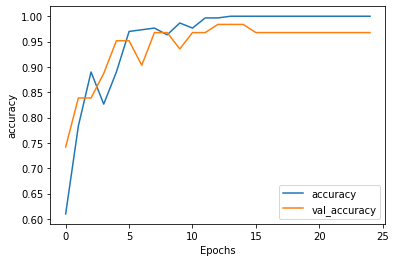

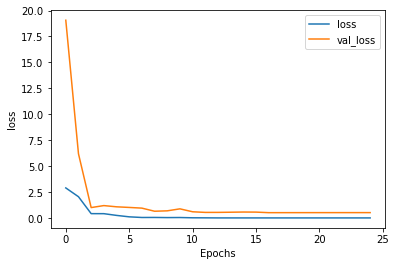

In [16]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [17]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

4/4 [==============================] - 2s 459ms/step - loss: 0.5113 - accuracy: 0.9677
Test Accuracy: 96.77%
10/10 [==============================] - 10s 880ms/step - loss: 2.9440e-05 - accuracy: 1.0000
Train Accuracy: 100.00%


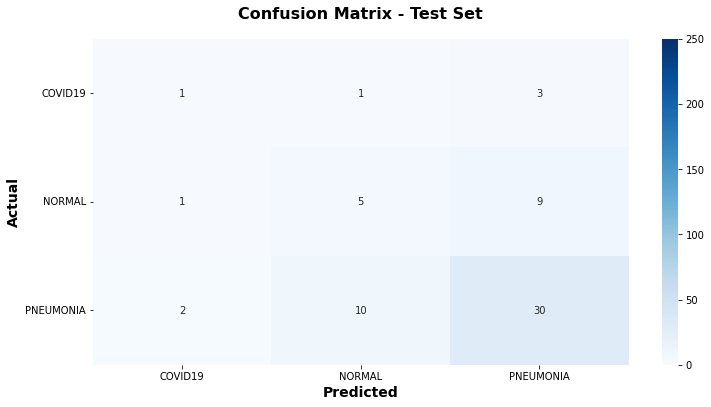

In [18]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 4. Model with small sample size (10%)
- Training Accuracy: 100%
- Testing Accuracy: 96.06%
- Note: Model results for that without dropout and augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 100%
  - Testing Accuracy: 96.12%

Image Pre-processing

In [ ]:
sample_train_dir = "/content/drive/My Drive/Data/unique_sample_train"
sample_test_dir = "/content/drive/My Drive/Data/unique_sample_test"

In [ ]:
print("Train set:\n========================================")
num_covid19 = len(os.listdir(os.path.join(sample_train_dir, 'COVID19')))
num_normal = len(os.listdir(os.path.join(sample_train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(sample_train_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19}")
print(f"NORMAL={num_normal}")
print(f"PNEUMONIA={num_pneumonia}")

print("Test set:\n========================================")
num_covid19_test = len(os.listdir(os.path.join(sample_test_dir, 'COVID19')))
num_normal_test = len(os.listdir(os.path.join(sample_test_dir, 'NORMAL')))
num_pneumonia_test = len(os.listdir(os.path.join(sample_test_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19_test}")
print(f"NORMAL={num_normal_test}")
print(f"PNEUMONIA={num_pneumonia_test}")

# Compute class weights
weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

Train set:
COVID19=134
NORMAL=126
PNEUMONIA=341
Test set:
COVID19=11
NORMAL=31
PNEUMONIA=85
Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


In [ ]:
img_size = 299

# Image Preprocessing to perform standardization
train_image_datagen = ImageDataGenerator(rescale=1./299)

train_datagen = train_image_datagen.flow_from_directory(sample_train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(sample_test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

Found 601 images belonging to 3 classes.
Found 127 images belonging to 3 classes.


In [ ]:
train_datagen.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

Model

In [ ]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("xception_10%sample.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
19/19 [==============================] - 179s 8s/step - loss: 2.4736 - accuracy: 0.6905 - val_loss: 0.5647 - val_accuracy: 0.8819

Epoch 00001: val_accuracy improved from -inf to 0.88189, saving model to xception_10%sample.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
19/19 [==============================] - 26s 1s/step - loss: 0.2834 - accuracy: 0.8519 - val_loss: 0.4248 - val_accuracy: 0.9370

Epoch 00002: val_accuracy improved from 0.88189 to 0.93701, saving model to xception_10%sample.h5
Epoch 3/20
19/19 [==============================] - 25s 1s/step - loss: 0.0941 - accuracy: 0.9434 - val_loss: 0.2423 - val_accuracy: 0.9370

Epoch 00003: val_accuracy did not improve from 0.93701
Epoch 4/20
19/19 [==============================] - 25s 1s/step - loss: 0.0174 - accuracy: 0.9800 - val_loss: 0.1258 - val_accuracy: 0.9606

Epoch 00004: val_accuracy improved from 0.93701 to 0.96063, saving model to xception_10%sample.h5
Epoch 5/20
19/19 [==============================] - 25s 1s/step - loss: 0.0094 - accuracy: 0.9900 - val_loss: 0.1452 - val_accuracy: 0.9606

Epoch 00005: val_accuracy did not improve from 0.96063
Epoch 6/20
19/19 [==============================] - 24s 1s/step - loss: 0.0283 - accuracy: 0.9651 - val_loss: 0.3736 - val_accurac

Model Evaluation

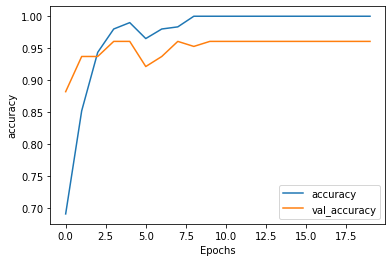

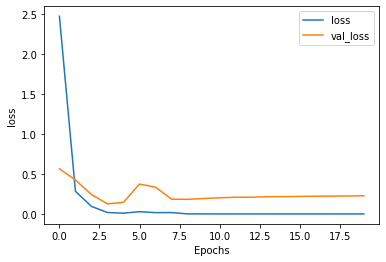

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

8/8 [==============================] - 4s 508ms/step - loss: 0.2278 - accuracy: 0.9606
Test Accuracy: 96.06%
19/19 [==============================] - 19s 1s/step - loss: 8.1701e-05 - accuracy: 1.0000
Train Accuracy: 100.00%


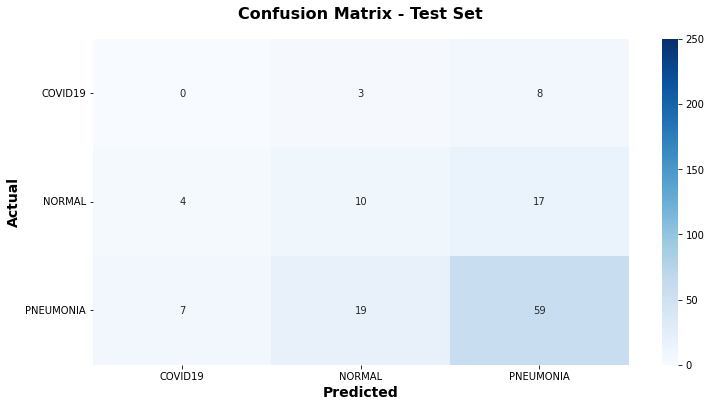

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 5. Model with smaller sample size (20%)
- Training Accuracy: 100%
- Testing Accuracy: 92.61%
- Note: Model results for that without dropout and augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 100%
  - Testing Accuracy: 96.12%

Image Pre-processing

In [ ]:
sample_train_dir = "/content/drive/My Drive/Data/unique_20_sample_train"
sample_test_dir = "/content/drive/My Drive/Data/unique_20_sample_test"

In [ ]:
print("Train set:\n========================================")
num_covid19 = len(os.listdir(os.path.join(sample_train_dir, 'COVID19')))
num_normal = len(os.listdir(os.path.join(sample_train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(sample_train_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19}")
print(f"NORMAL={num_normal}")
print(f"PNEUMONIA={num_pneumonia}")

print("Test set:\n========================================")
num_covid19_test = len(os.listdir(os.path.join(sample_test_dir, 'COVID19')))
num_normal_test = len(os.listdir(os.path.join(sample_test_dir, 'NORMAL')))
num_pneumonia_test = len(os.listdir(os.path.join(sample_test_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19_test}")
print(f"NORMAL={num_normal_test}")
print(f"PNEUMONIA={num_pneumonia_test}")

# Compute class weights
weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

Train set:
COVID19=269
NORMAL=253
PNEUMONIA=683
Test set:
COVID19=23
NORMAL=63
PNEUMONIA=171
Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


In [ ]:
img_size = 299

# Image Preprocessing to perform standardization
train_image_datagen = ImageDataGenerator(rescale=1./299)

train_datagen = train_image_datagen.flow_from_directory(sample_train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(sample_test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

Found 1205 images belonging to 3 classes.
Found 257 images belonging to 3 classes.


Model

In [ ]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("xception_20%sample.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
38/38 [==============================] - 305s 8s/step - loss: 1.2981 - accuracy: 0.7876 - val_loss: 0.7492 - val_accuracy: 0.9261

Epoch 00001: val_accuracy improved from -inf to 0.92607, saving model to xception_20%sample.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
38/38 [==============================] - 47s 1s/step - loss: 0.2079 - accuracy: 0.9261 - val_loss: 0.5646 - val_accuracy: 0.9183

Epoch 00002: val_accuracy did not improve from 0.92607
Epoch 3/20
38/38 [==============================] - 46s 1s/step - loss: 0.0783 - accuracy: 0.9527 - val_loss: 0.8577 - val_accuracy: 0.9261

Epoch 00003: val_accuracy did not improve from 0.92607
Epoch 4/20
38/38 [==============================] - 46s 1s/step - loss: 0.0671 - accuracy: 0.9685 - val_loss: 0.5476 - val_accuracy: 0.9261

Epoch 00004: val_accuracy did not improve from 0.92607
Epoch 5/20
38/38 [==============================] - 46s 1s/step - loss: 0.0225 - accuracy: 0.9859 - val_loss: 0.5691 - val_accuracy: 0.9222

Epoch 00005: val_accuracy did not improve from 0.92607
Epoch 6/20
38/38 [==============================] - 46s 1s/step - loss: 0.0451 - accuracy: 0.9793 - val_loss: 0.5397 - val_accuracy: 0.9339

Epoch 00006: val_accuracy improved from 0.92607 to 0.93385, saving model to

Model Evaluation

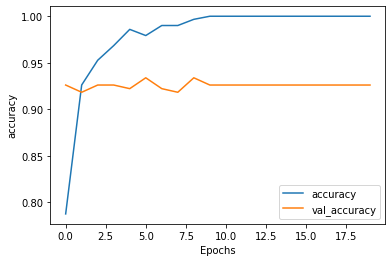

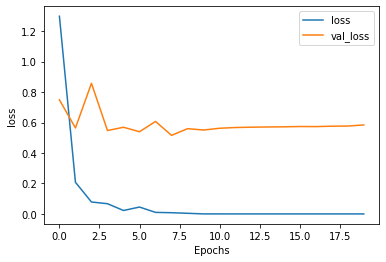

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

17/17 [==============================] - 9s 516ms/step - loss: 0.5843 - accuracy: 0.9261
Test Accuracy: 92.61%
38/38 [==============================] - 38s 988ms/step - loss: 1.1245e-05 - accuracy: 1.0000
Train Accuracy: 100.00%


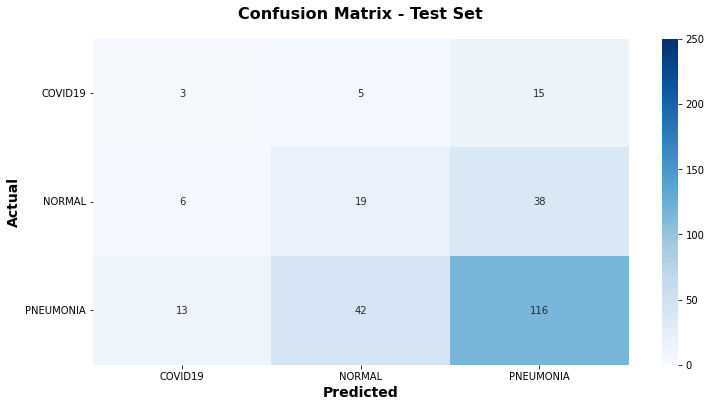

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 6. Model with smaller sample size (60%)
- Training Accuracy: 100%
- Testing Accuracy: 95.73%
- Note: Model results for that without dropout and augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 100%
  - Testing Accuracy: 96.12%

Image Pre-processing

In [ ]:
sample_train_dir = "/content/drive/My Drive/Data/unique_60_sample_train"
sample_test_dir = "/content/drive/My Drive/Data/unique_60_sample_test"

In [ ]:
print("Train set:\n========================================")
num_covid19 = len(os.listdir(os.path.join(sample_train_dir, 'COVID19')))
num_normal = len(os.listdir(os.path.join(sample_train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(sample_train_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19}")
print(f"NORMAL={num_normal}")
print(f"PNEUMONIA={num_pneumonia}")

print("Test set:\n========================================")
num_covid19_test = len(os.listdir(os.path.join(sample_test_dir, 'COVID19')))
num_normal_test = len(os.listdir(os.path.join(sample_test_dir, 'NORMAL')))
num_pneumonia_test = len(os.listdir(os.path.join(sample_test_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19_test}")
print(f"NORMAL={num_normal_test}")
print(f"PNEUMONIA={num_pneumonia_test}")

# Compute class weights
weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

Train set:
COVID19=809
NORMAL=759
PNEUMONIA=2050
Test set:
COVID19=69
NORMAL=190
PNEUMONIA=513
Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


In [ ]:
img_size = 299

# Image Preprocessing to perform standardization
train_image_datagen = ImageDataGenerator(rescale=1./299)

train_datagen = train_image_datagen.flow_from_directory(sample_train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(sample_test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

Found 3618 images belonging to 3 classes.
Found 772 images belonging to 3 classes.


Model

In [ ]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("xception_60%sample.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
114/114 [==============================] - 923s 8s/step - loss: 0.6618 - accuracy: 0.8618 - val_loss: 1.0182 - val_accuracy: 0.8251

Epoch 00001: val_accuracy improved from -inf to 0.82513, saving model to xception_60%sample.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
114/114 [==============================] - 153s 1s/step - loss: 0.0734 - accuracy: 0.9439 - val_loss: 0.1005 - val_accuracy: 0.9611

Epoch 00002: val_accuracy improved from 0.82513 to 0.96114, saving model to xception_60%sample.h5
Epoch 3/20
114/114 [==============================] - 148s 1s/step - loss: 0.0256 - accuracy: 0.9696 - val_loss: 0.1518 - val_accuracy: 0.9482

Epoch 00003: val_accuracy did not improve from 0.96114
Epoch 4/20
114/114 [==============================] - 144s 1s/step - loss: 0.0226 - accuracy: 0.9760 - val_loss: 0.1065 - val_accuracy: 0.9573

Epoch 00004: val_accuracy did not improve from 0.96114
Epoch 5/20
114/114 [==============================] - 143s 1s/step - loss: 0.0147 - accuracy: 0.9854 - val_loss: 0.1523 - val_accuracy: 0.9469

Epoch 00005: val_accuracy did not improve from 0.96114
Epoch 6/20
114/114 [==============================] - 143s 1s/step - loss: 0.0144 - accuracy: 0.9837 - val_loss: 0.1804 - val_accuracy: 0.9534

Epoch 00006: val_

Model Evaluation

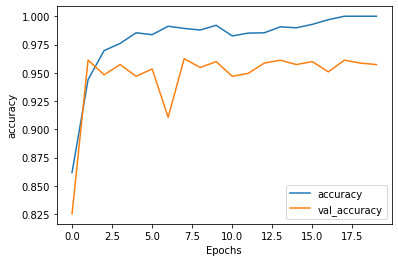

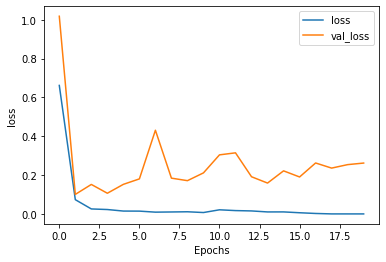

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

49/49 [==============================] - 24s 491ms/step - loss: 0.2620 - accuracy: 0.9573
Test Accuracy: 95.73%
114/114 [==============================] - 111s 968ms/step - loss: 2.8468e-05 - accuracy: 1.0000
Train Accuracy: 100.00%


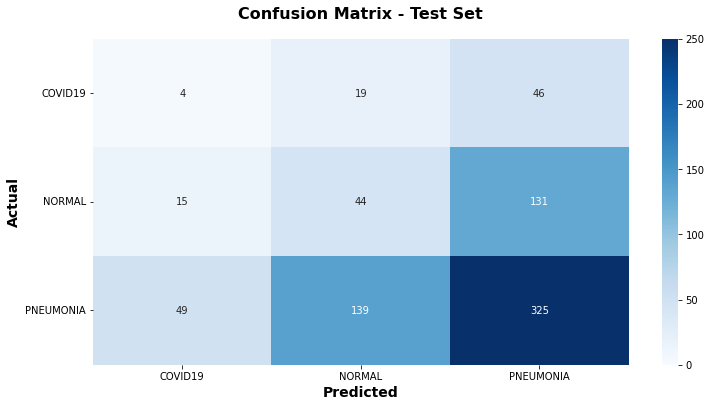

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);